<h1 style="text-align:center;">Claim Travel Insurance Prediction</h1>

### `Initial Setup`

In [1]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
import time
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, precision_recall_curve, auc, recall_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

### `Business Problem Understanding`

**Context**

Perusahaan asuransi travel ingin mengetahui perilaku pelanggan terkait klaim asuransi dengan cara mengidentifikasi pola atau faktor yang mempengaruhi keputusan pelanggan apakah akan mengajukan klaim asuransi atau tidak. Data yang dipakai meliputi agency, agency type, distribution channel, product name, duration, destination, net sales, commision, age, dan sejarah klaim.

Target:

0 : Nasabah tidak mengajukan klaim asuransi

1 : Nasabah mengajukan klaim asuransi

**Problem Statement**

Perusahaan asuransi travel menangggung biaya yang akan diklaim oleh nasabah berdasarkan tipe produk asuransi yang dipilih oleh nasabah. Biaya yang diklaim meliputi kerugian nasabah selama perjalanan. Untuk menghindari kerugian yang besar, perusahaan ingin melakukan prediksi terhadap nasabah yang  berpotensi mengajukan klaim dan yang tidak.

**Goals**

Perusahaan dapat membangun model prediksi yang dapat mengklasifikasikan nasabah yang berpotensi mengajukan klaim asuransi dan nasabah yang kemungkinan besar tidak akan mengajukan klaim. Prediksi ini dilakukan untuk menghindari kerugian akibat nasabah yang mengajukan klaim tetapi melebihi premi yang sudah dibayarkan.

**Analytic Approach**

Menganalisis data untuk menemukan pola atau faktor yang mempengaruhi nasabah mengajukan klaim asuransi travel atau tidak.

Kemudian membangun model kalsifikasi yang membandtu perusahaan untuk memprediksi probabilitas nasabah yang akan mengajukan klaim asurasni atau tidak.

**Metric Evaluation**

Type 1 error: False Positive
<br>
Konsekuensi: Perusahaan mengalami kerugian karena nasabah tidak mengajukan klaim


Type 2 error: False Negative
<br>
Konsekuensi: Perusahaan kehilangan kepercayaan nasabah karena nasabah mengajukan klaim serta berdampak pada kerugian finansial perusahaan

Berdasarkan konsekuensinya, maka sebisa mungkin membuat model yang dapat mengurangi kerugian perusahaan dengan cara memperbanyak prediksi nasabah yang benar benar mengajukan klaim dan nasabah yang tidak mengajukan klaim. Jadi metric yang akan dipakai adalah Precision Recall Curve karena lebih membutuhkan perhitungan true positif serta terdapat imbalance data.

### `Data Understanding`

Dataset source: https://drive.google.com/drive/folders/1iVx5k6tWglqfHb05o0DElg8JHg7VVG_J

| Columns                                            | Definition                                                   | 
| ------------------------------------------------- | ------------------------------------------------------------ |
| Agency | Name of agency |
| Agency Type | Type of travel insurance agencies |
| Distribution Channel | Channel of travel insurance agencies |
| Product Name | Name of the travel insurance products |
| Gender | Gender of insured |
| Duration | Duration of travel |
| Destination | Destination of travel |
| Net Sales | Amount of sales of travel insurance policies |
| Commission (in value) | Commission received for travel insurance agency |
| Age | Age of insured |
| Claim | Claim status |


In [2]:
data = pd.read_csv('data_travel_insurance.csv')
print(f'Jumlah baris dan kolom: {data.shape}')
display(data.head(), data.tail())

Jumlah baris dan kolom: (44328, 11)


,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No
44327,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,172,SINGAPORE,0.0,17.82,31,No


#### **Initial Assesment**

In [3]:
print(f'Jumlah baris dan kolom: {data.shape}')

pd.DataFrame({
    'column': data.columns.values,
    'type': data.dtypes.values,
    'n_unique': data.nunique().values,
    # 'min': data.min().values,
    # 'max': data.max().values,
    'sample_unique': [data[col].unique() for col in data.columns]
})

Jumlah baris dan kolom: (44328, 11)


,column,type,n_unique,sample_unique
0,Agency,object,16,"[C2B, EPX, JZI, CWT, LWC, ART, CSR, SSI, RAB, ..."
1,Agency Type,object,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,2,"[Online, Offline]"
3,Product Name,object,26,"[Annual Silver Plan, Cancellation Plan, Basic ..."
4,Gender,object,2,"[F, nan, M]"
5,Duration,int64,437,"[365, 4, 19, 20, 8, 2, 25, 90, 24, 43, 103, 37..."
6,Destination,object,138,"[SINGAPORE, MALAYSIA, INDIA, UNITED STATES, KO..."
7,Net Sales,float64,1006,"[216.0, 10.0, 22.0, 112.0, 16.0, 50.0, 78.0, 8..."
8,Commision (in value),float64,915,"[54.0, 0.0, 7.7, 4.0, 9.1, 63.21, 10.5, 11.88,..."
9,Age,int64,89,"[57, 33, 26, 59, 28, 36, 22, 39, 27, 48, 43, 5..."


__Insight :__
* Dataset travel insurance memiliki 11 kolom dan 44328 baris, dimana setiap baris mempresentasikan nasabah yang memiliki tarvel insurance
* Variabel numerik yaitu duration, net sales, commision (in value), dan age
* Variabel kategorikal yaitu agency, agency type, distribution channel, product name, gender, destination, dan claim
* Tipe data dari variabel sudah sesuai

#### **Numerical variable**

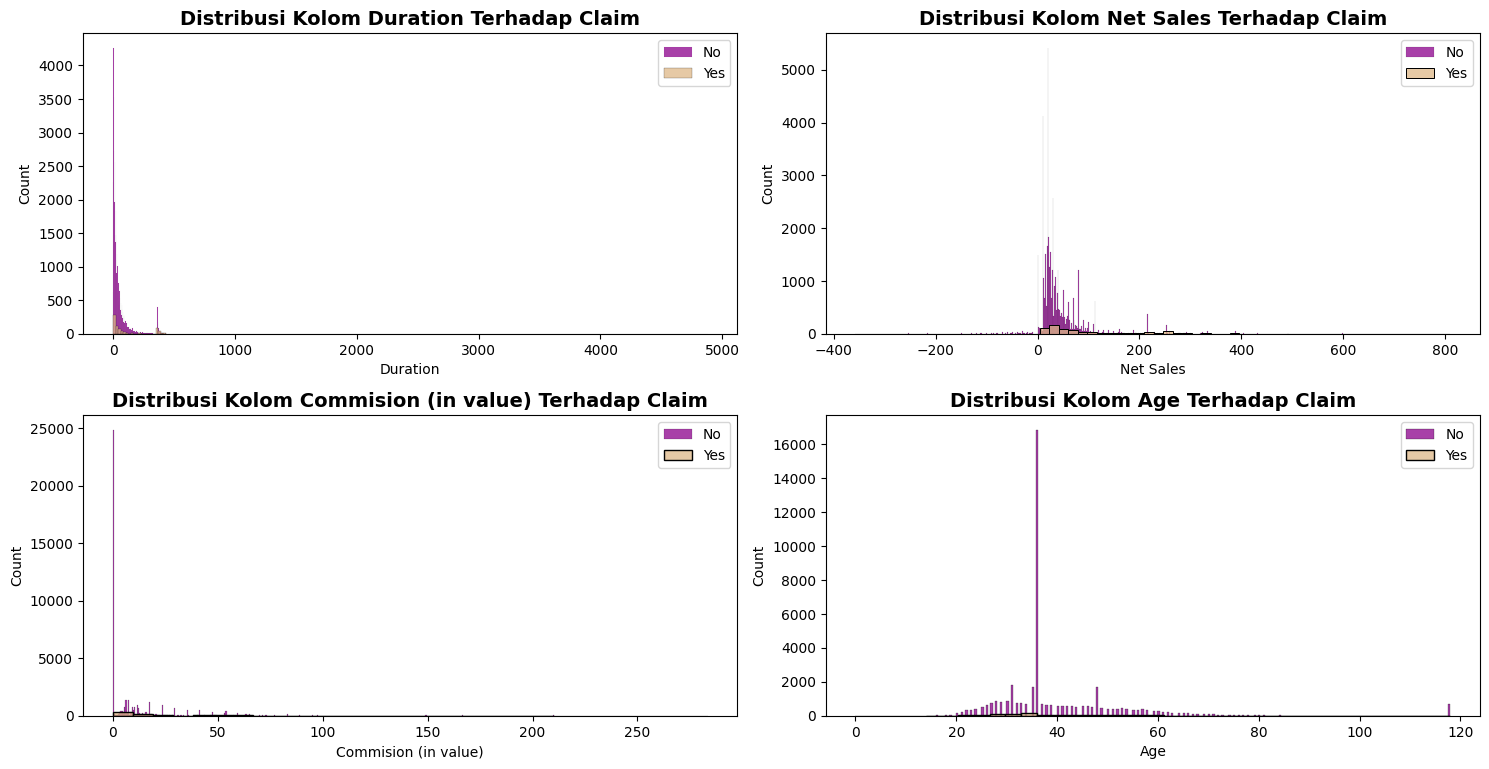

In [4]:
numerical = ['Duration', 'Net Sales', 'Commision (in value)', 'Age']

plt.figure(figsize=(15, 15))
cmap = plt.get_cmap('flare')

a = 1
for i in numerical:
    plt.subplot(4, 2, a)
    sns.histplot(x=data[data['Claim']=="No"][i], color="DarkMagenta")
    sns.histplot(x=data[data['Claim']=="Yes"][i], color="BurlyWood")
    plt.legend(labels=['No', 'Yes'])
    plt.tight_layout()
    plt.title(f'Distribusi Kolom {i} Terhadap Claim', fontsize=14, weight='bold')
    a += 1

plt.show()

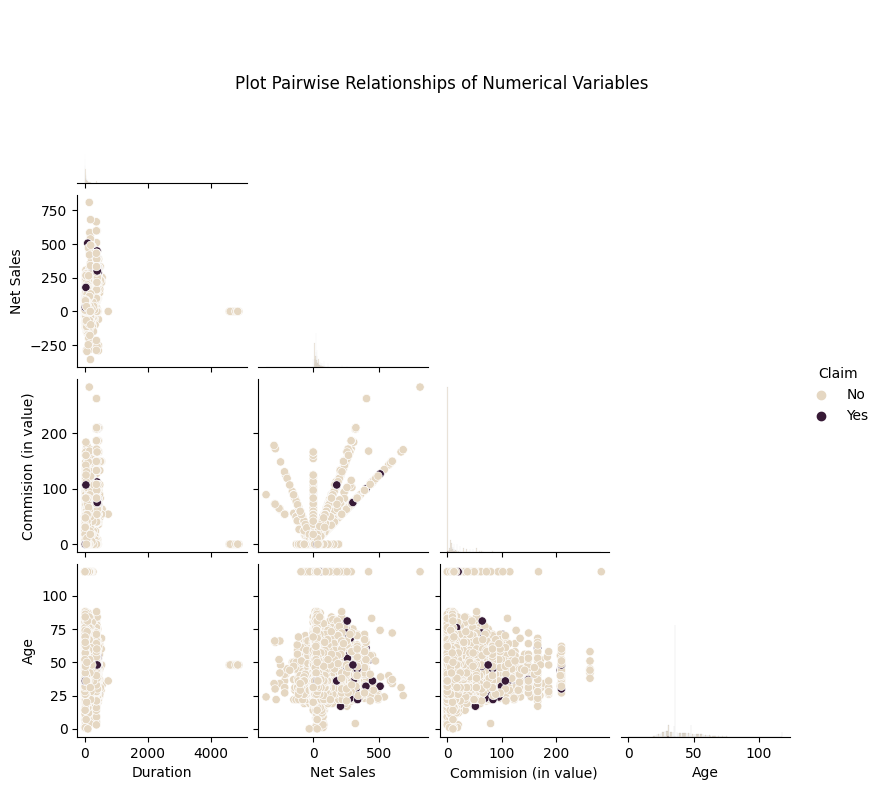

In [5]:
numerical = [var for var in data.columns if data[var].dtype != 'categorical']

graph = sns.pairplot(
    data[numerical], 
    height=2.0, corner=True, 
    diag_kind='hist', 
    hue='Claim', 
    palette='ch:.25')

graph.fig.suptitle("Plot Pairwise Relationships of Numerical Variables", y=0.9)
plt.show()
plt.show()

__Insight :__
* Terdapat 2 variabel kontinu, yaitu net sales dan commision (in value)
* Terdapat 2 variabel diskrit, yaitu duration dan age
* Terdapat rentang nilai yang sangat jauh pada variabel duration
* Persebaran data cukup tinggi

#### **Categorical variable**

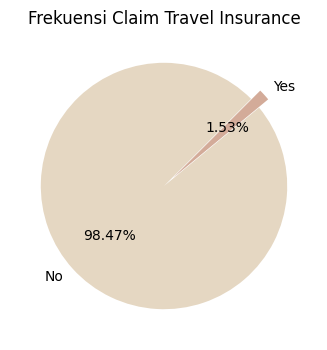

In [6]:
# Pie Chart
ax = data.Claim.value_counts(normalize=True) * 100
plt.subplots(figsize=(8, 4))
plt.title("Frekuensi Claim Travel Insurance")
plt.pie(
    x=[ax.loc['No'], ax.loc['Yes']], 
    explode= (0,0.1),
    labels=['No', 'Yes'], 
    colors=sns.color_palette('ch:.25'), 
    autopct='%.2f%%',
    startangle=45)

plt.show()

No     43651
Yes      677
Name: Claim, dtype: int64


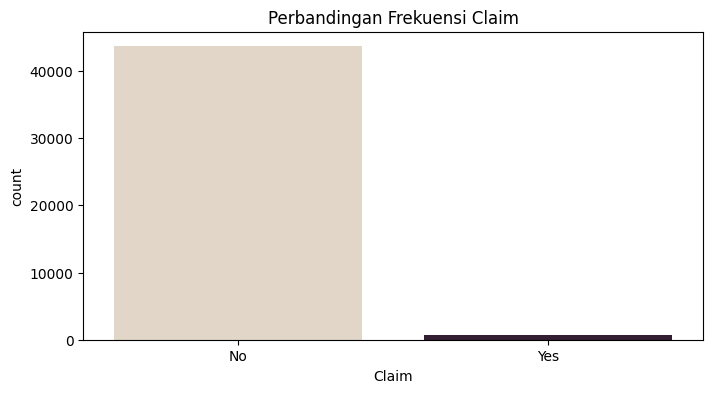

In [7]:
plt.subplots(figsize=(8, 4))
plt.title("Perbandingan Frekuensi Claim")
print(data.Claim.value_counts())
ay = sns.countplot(data=data, x="Claim", palette="ch:.25")


plt.show()

__Insight :__
* Perbandingan data nasabah yang mengajukan claim(Yes), 98.47%, lebih banyak dibandingkan nasabah yang tidak claim(No) 1.53%. Data ini menyababkan terjadinya imbalance data.

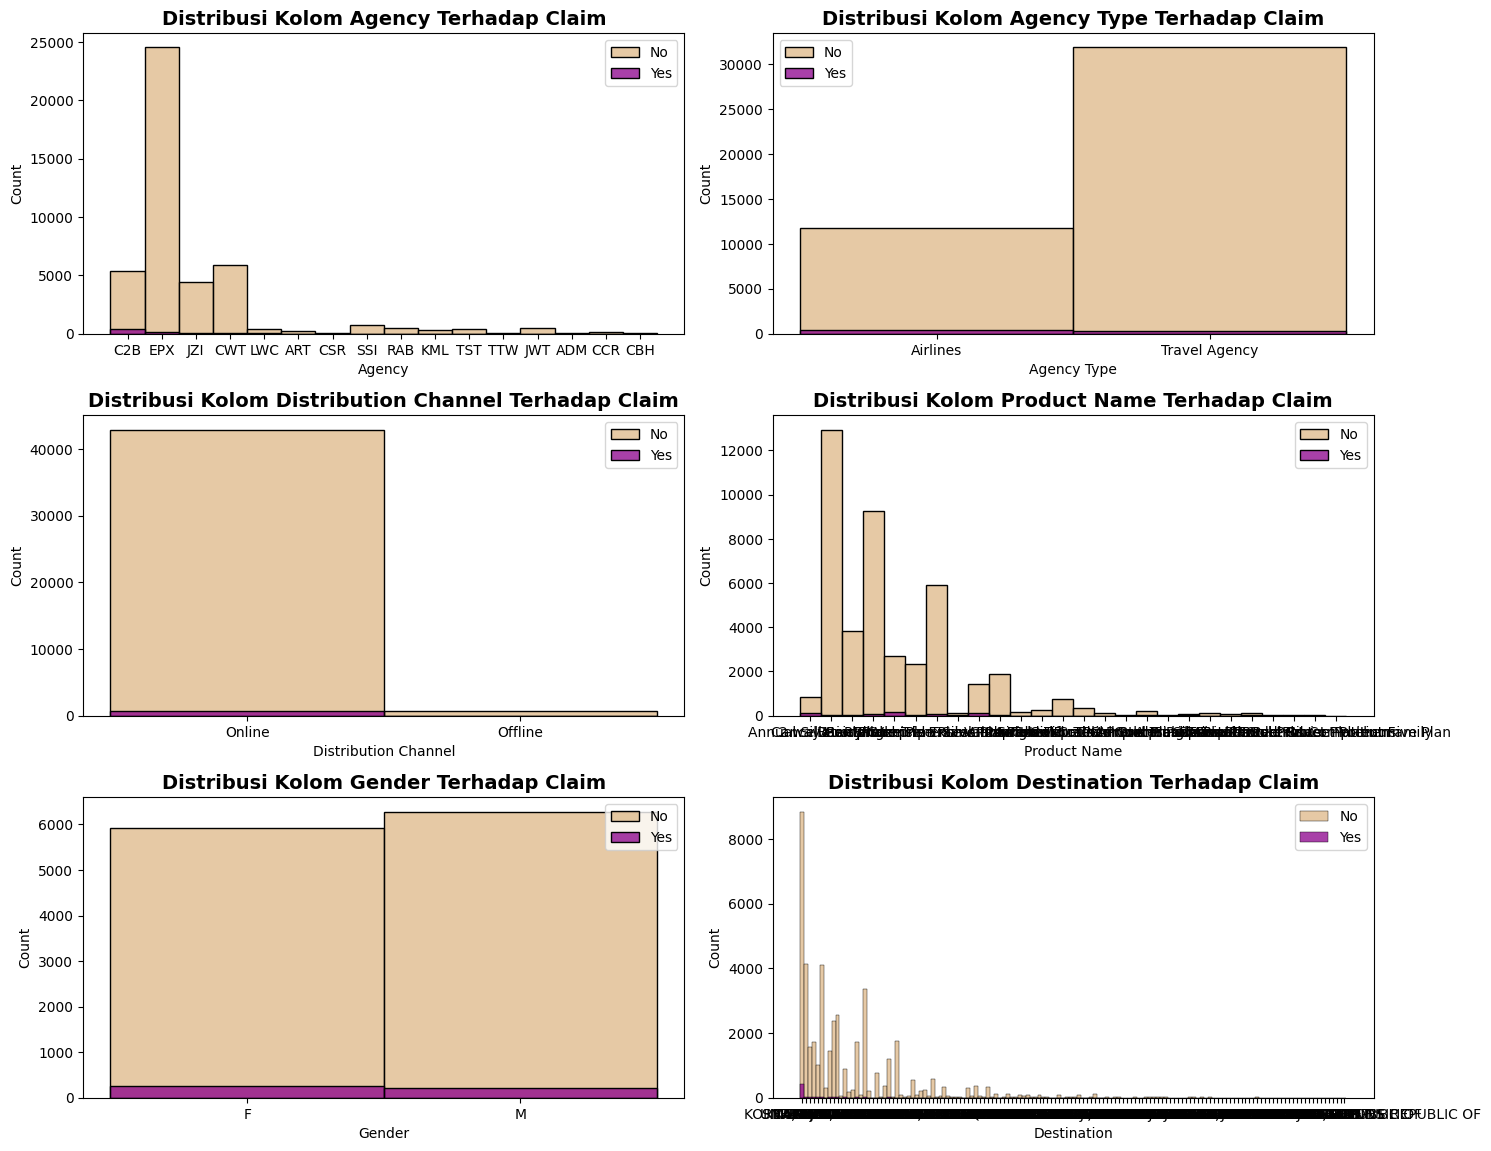

In [8]:
categorical = ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Gender', 'Destination']

plt.figure(figsize=(15, 15))
cmap = plt.get_cmap('summer')

a = 1
for i in categorical:
    plt.subplot(4, 2, a)
    sns.histplot(x=data[data['Claim']=="No"][i], color="BurlyWood")
    sns.histplot(x=data[data['Claim']=="Yes"][i], color="DarkMagenta")
    plt.legend(labels=['No', 'Yes'])
    plt.tight_layout()
    plt.title(f'Distribusi Kolom {i} Terhadap Claim', fontsize=14, weight='bold')
    a += 1

plt.show()

__Insight :__
* Terdapat 6 kolom variabel kategorikal yaitu Agency, Agency Type, Distribution Channel. Product Name, Gender, Claim
* Pada kolom distribution channel, product name, destination memiliki value yang tinggi, dan akan dilakukan pengecekan apakah ada rare value yang harus dihandle atau tidak.
* Perusahaan lebih efektif menjual product dengan cara online

### `Data Preparation`

In [9]:
df = data.copy()
display(df.head(), df.tail())

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No
44327,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,172,SINGAPORE,0.0,17.82,31,No


#### **Data Wrangling**

**Missing Value**

Deteksi dan kuantifikasi missing value:

(Agency                      0
 Agency Type                 0
 Distribution Channel        0
 Product Name                0
 Gender                  31647
 Duration                    0
 Destination                 0
 Net Sales                   0
 Commision (in value)        0
 Age                         0
 Claim                       0
 dtype: int64,
 <Axes: >)

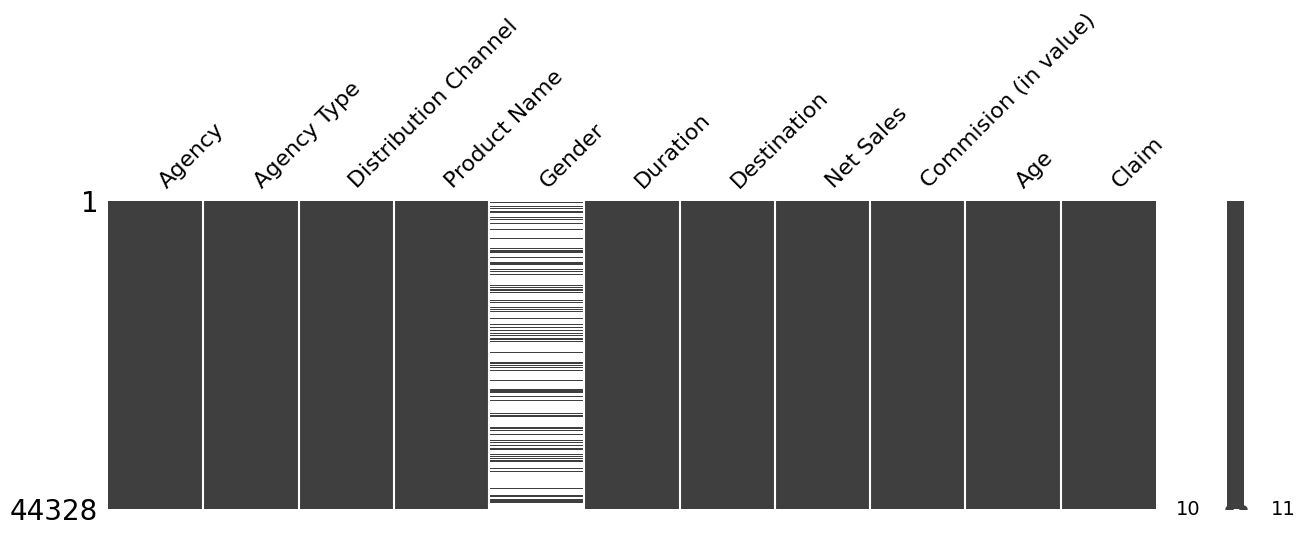

In [10]:
import missingno as msno
data.isna().sum(), msno.matrix(data, figsize=(15, 8))

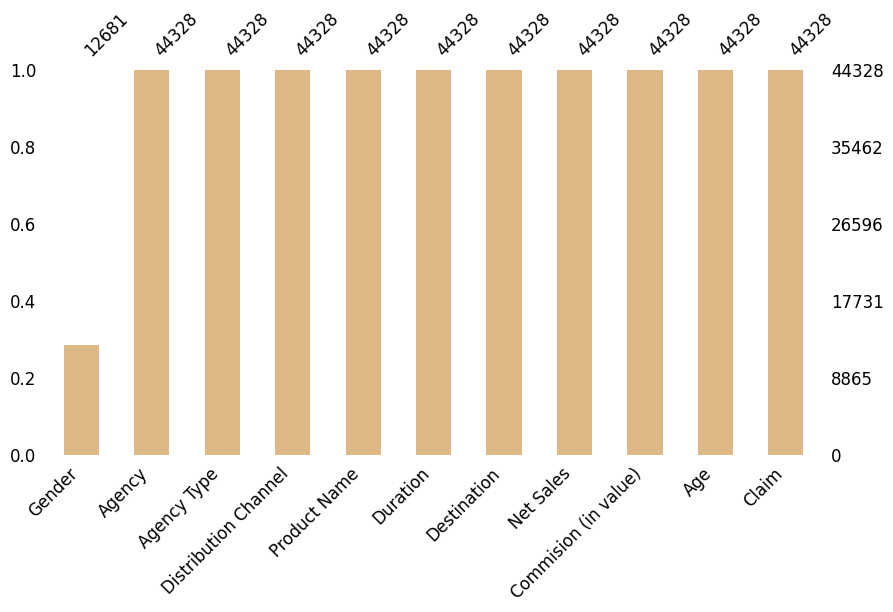

In [11]:
import missingno as msno
msno.bar(df, color="BurlyWood",sort="ascending", figsize=(10,5), fontsize=12);

Handling missing value:

In [12]:
df.drop(['Gender'], axis=1, inplace=True)

__Insight :__ 
* Terdapat missing value sebanyak 31647 pada kolom gender
* dalam kasus ini untuk menghandle missing value dilakukan delete kolom gender karena kolom gender tidak menjadi faktor utama untuk melakukan proses claim travel asurasni.

**Duplicated Value**, Deteksi dan kuantifikasi duplikasi data:

In [13]:
duplicated = df.duplicated().sum()
duplicatedPerc = round((df.duplicated().sum()/df.shape[0])*100,2)
print(f'Jumlah Data Duplikat: {duplicated}\nPersentase Data Duplikat: {duplicatedPerc}%')
print(f'Jumlah baris dan kolom: {df.shape}')

Jumlah Data Duplikat: 5004
Persentase Data Duplikat: 11.29%
Jumlah baris dan kolom: (44328, 10)


Handling duplikasi data:

In [14]:
df.drop_duplicates(keep='first', inplace=True, ignore_index=True)

duplicated = df.duplicated().sum()
duplicatedPerc = round((df.duplicated().sum()/df.shape[0])*100,2)
print(f'Jumlah Data Duplikat: {duplicated}\nPersentase Data Duplikat: {duplicatedPerc}%')
print(f'Jumlah baris dan kolom: {df.shape}')

Jumlah Data Duplikat: 0
Persentase Data Duplikat: 0.0%
Jumlah baris dan kolom: (39324, 10)


__Insight :__
* Pada dataset travel insurance terdapat data duplikat sebesar 11.29%

**Data Anomali**

In [15]:
print(f'Pada kolom Duration terdapat {(sum(df["Duration"] > 547)/len(df)*100)}% data yang melebihi batas 3 bulan')
print(f'Pada kolom Duration terdapat {(sum(df["Duration"] < 1)/len(df)*100)}% data yang kurang dari 1 hari')

#Delete Anomali Data
df.drop(df[(df.Duration > 547) | (df.Duration < 1)].index, inplace=True)

Pada kolom Duration terdapat 0.035601668192452446% data yang melebihi batas 3 bulan
Pada kolom Duration terdapat 0.091547146780592% data yang kurang dari 1 hari


__Insight :__
* dataseb travel insurance memiliki data dengan duration melebihi 3 bulan atau kurang dari 1 hari, dimana travel insurance hanya dapat memfasilitasi nasabah dengan durasi perjalanan minimal 1 hari dan maksimal 3 bulan atau 547 hari. ***[data](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjJtZbS3MeAAxWmUGwGHV5TATsQFnoECBIQAw&url=https%3A%2F%2Fwww.gocompare.com%2Ftravel-insurance%2Flong-stay-cover%2F%23%3A~%3Atext%3DLong%252Dstay%2520travel%2520insurance%2520covers%2Caway%2520from%2520the%2520British%2520winter.&usg=AOvVaw3Li5Md6rjVbG2BcAqBCo_1&opi=89978449)***

**Rare label**

Deteksi dan kuantifikasi rare value:

1. Numerical

In [16]:
df.describe()

,Duration,Net Sales,Commision (in value),Age
count,39274.000000,39274.000000,39274.000000,39274.000000
mean,50.746372,42.238035,10.390580,39.813159
std,74.188871,49.718840,20.353646,13.182289
min,1.000000,-357.500000,0.000000,0.000000
25%,11.000000,19.000000,0.000000,35.000000
50%,25.000000,29.000000,0.000000,36.000000
75%,57.000000,50.000000,11.880000,44.000000
max,547.000000,810.000000,283.500000,118.000000


In [17]:
df.Profit = df['Net Sales'].apply(lambda x: 'Yes' if x > 0 else 'No')
df['Net Sales'] = df['Net Sales'].abs()

2. Categorical

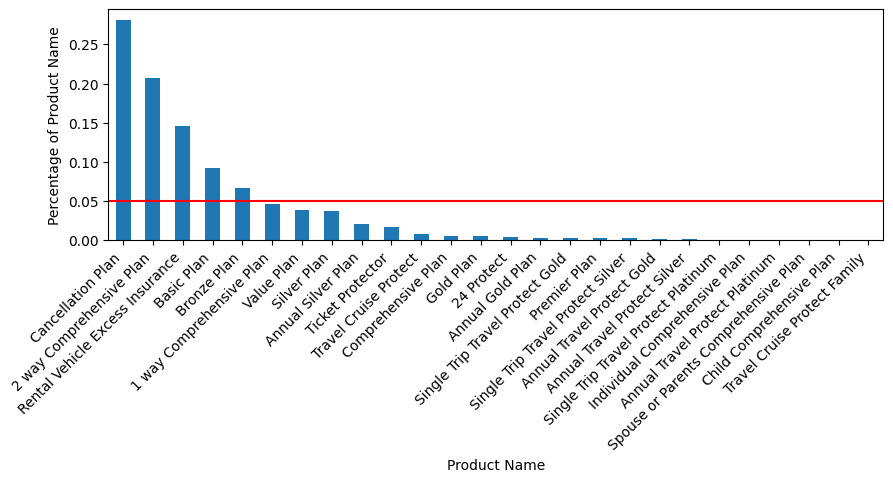

In [18]:
temp_df = pd.Series(df['Product Name'].value_counts() / len(df))

plt.figure(figsize=(10, 3))
fig = temp_df.sort_values(ascending=False).plot.bar(rot=0)
fig.set_xlabel('Product Name')
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')

fig.axhline(y=0.05, color='red')
fig.set_ylabel('Percentage of Product Name')
plt.show()

Handling rare value:

In [19]:
dropProduct = temp_df[temp_df < 0.5].index
df = df[df['Product Name'].isin(dropProduct)]
df.reset_index(drop=True)

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...
39269,EPX,Travel Agency,Online,2 way Comprehensive Plan,14,CHINA,30.0,0.00,36,Yes
39270,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,79.2,47.52,47,No
39271,TST,Travel Agency,Offline,Travel Cruise Protect,64,THAILAND,30.0,10.50,50,No
39272,EPX,Travel Agency,Online,2 way Comprehensive Plan,51,CHINA,36.0,0.00,36,No


__Insight :__ 
* Pada kolom product name terdapat rare valu yang banyak karena jenis product yang ditawarkan asuransi sangat banyak.
* Untuk menghandle rare value pada kolom product name, dilakukan delete product name yang memiliki jumlah nasabah kurang dari 5%

**Outlier**

Deteksi dan kuantifikasi outlier:

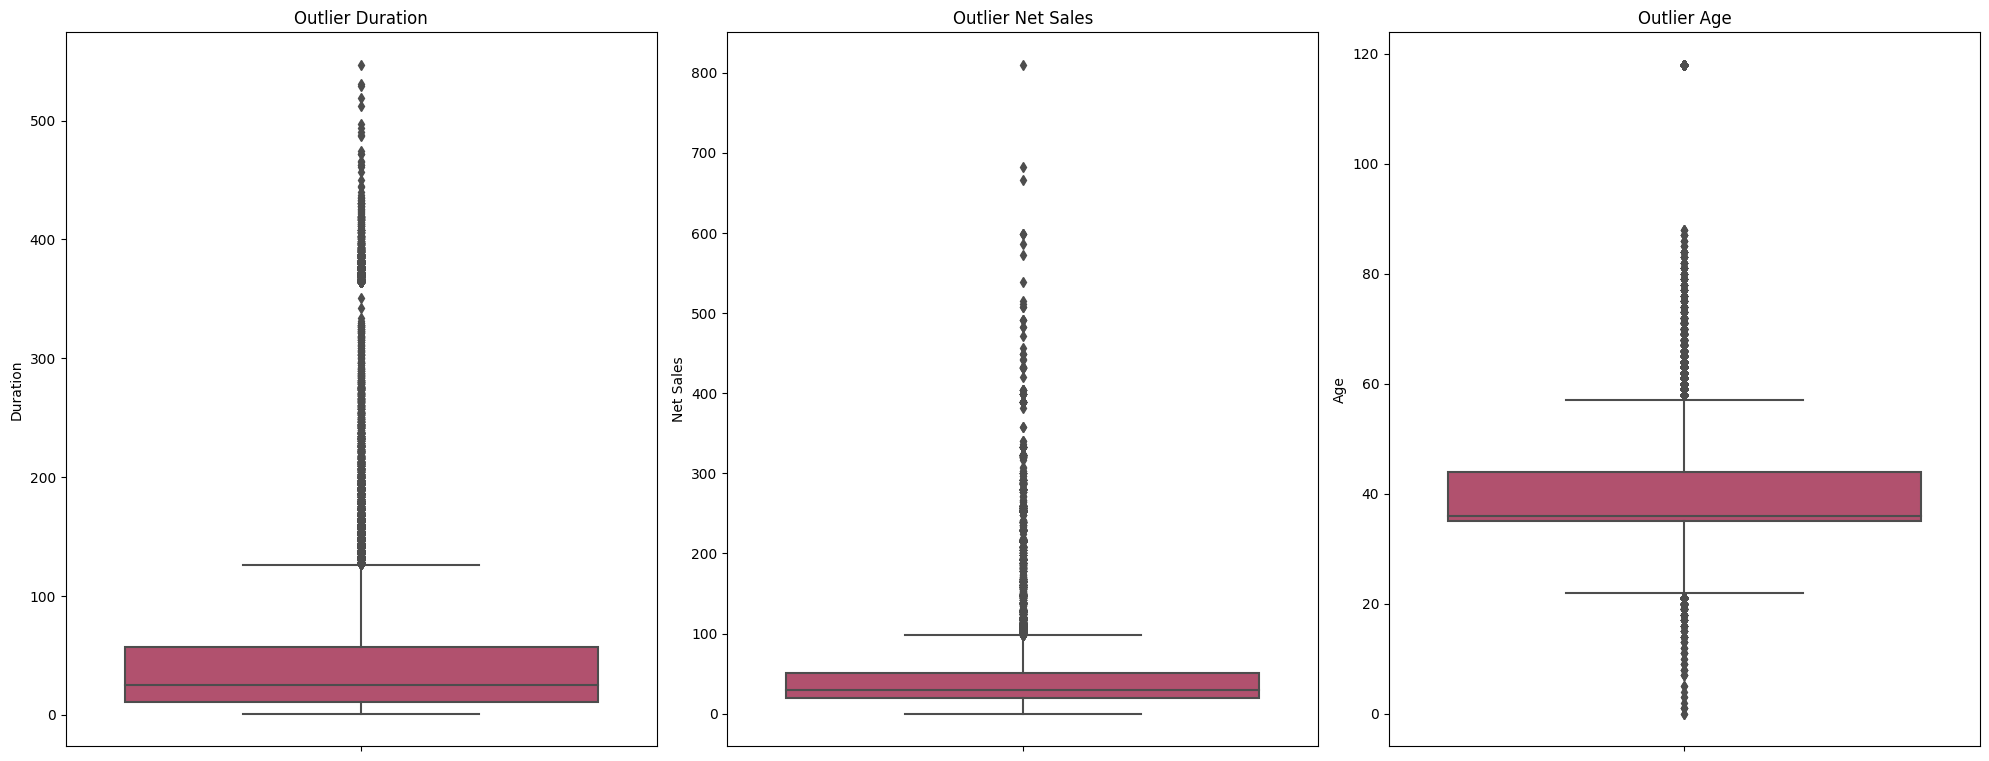

In [20]:
numerical = ['Duration', 'Net Sales', 'Age']

plt.figure(figsize=(20, 15))
for i in range(len(numerical)):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df[numerical[i]], palette="flare")
    plt.title(f"Outlier {numerical[i]}", fontsize=12, ha="center")

plt.tight_layout()
plt.show()

In [21]:
numerical = ['Duration', 'Net Sales', 'Age']

def outliersInsurance(Insurance):
    Insurance = pd.Series(Insurance)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound =  Q1 - (1.5 * IQR)
    upper_bound =  Q3 + (1.5 * IQR)
    outliers = df[(df < lower_bound) | (df > upper_bound)]
    return outliers    

out = {}
out['outDuration'] = outliersInsurance(df[df['Claim'] == 'Yes']['Duration'])
out['outNetSales'] = outliersInsurance(df[df['Claim'] == 'Yes']['Net Sales'])
print(f'Outlier Multivariative Claim Yes: {len(df[(df["Duration"].isin(out["outDuration"])) & df["Net Sales"].isin(out["outNetSales"])])}')

out['outDuration'] = outliersInsurance(df[df['Claim'] == 'No']['Duration'])
out['outNetSales'] = outliersInsurance(df[df['Claim'] == 'No']['Net Sales'])
print(f'Outlier Multivariative Claim No: {len(df[(df["Duration"].isin(out["outDuration"])) & df["Net Sales"].isin(out["outNetSales"])])}')

Outlier Multivariative Claim Yes: 0
Outlier Multivariative Claim No: 0


In [22]:
from sklearn.preprocessing import RobustScaler

# Scalling Net Sales and Duration
NetSalesYes = df[df["Claim"] == "Yes"]["Net Sales"].values.reshape(-1, 1)
NetSalesNo = df[df["Claim"] == "No"]["Net Sales"].values.reshape(-1, 1)

DurationYes = df[df["Claim"] == "Yes"]["Duration"].values.reshape(-1, 1)
DurationNo = df[df["Claim"] == "No"]["Duration"].values.reshape(-1, 1)

# Initialize the RobustScaler
scaler = RobustScaler()

if len(NetSalesYes) > 0:
    df.loc[df["Claim"] == "Yes", "Net Sales"] = scaler.fit_transform(NetSalesYes)
if len(NetSalesNo) > 0:
    df.loc[df["Claim"] == "No", "Net Sales"] = scaler.fit_transform(NetSalesNo)

if len(DurationYes) > 0:
    df.loc[df["Claim"] == "Yes", "Net Sales"] = scaler.fit_transform(DurationYes)
if len(DurationNo) > 0:
    df.loc[df["Claim"] == "No", "Net Sales"] = scaler.fit_transform(DurationNo)

__Insight :__
* Untuk outlier univariative terdapat banyak outlier pada kolom Net Sales, Age, dan Duration
* Untuk outlier multivariative tidak terdapat outlier pada kolom Net Sales, Age, dan Duration
* Untuk menghandle outlier univariative dilakukan scalling menggunakan median dengan robustscaler

#### **Feature Engineering**

Feature Selection:

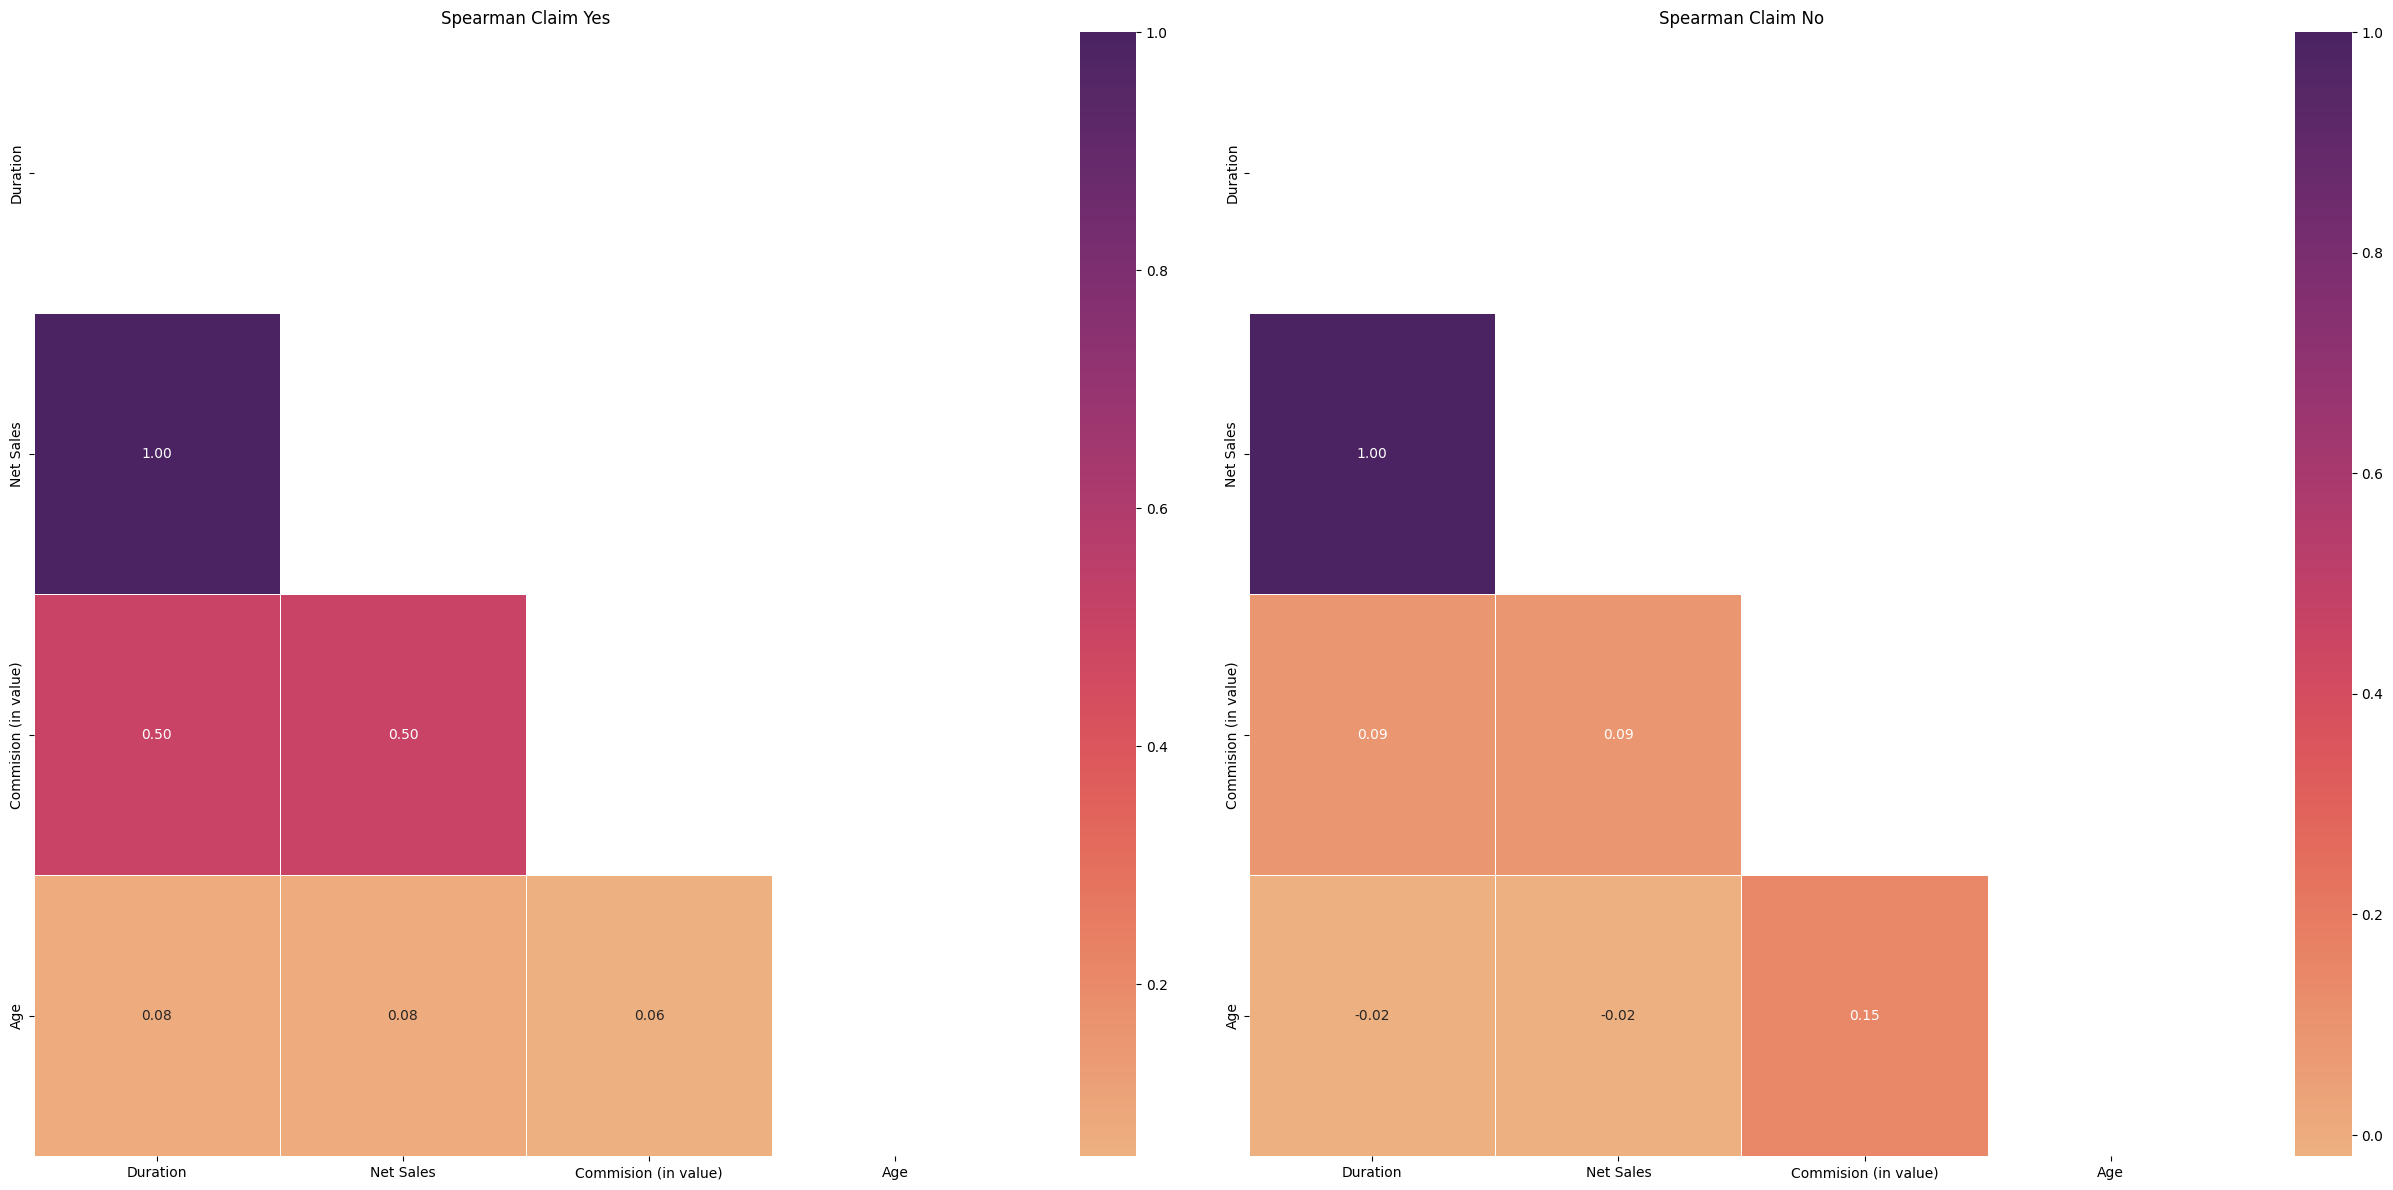

In [23]:
claimYes = df[df['Claim'] == "Yes"].corr(method='spearman')
claimNo = df[df['Claim'] == "No"].corr(method='spearman')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))

# Claim Yes
maskYes = np.triu(np.ones_like(claimYes, dtype=bool))
sns.heatmap(claimYes, ax=ax1, annot=True, cmap='flare', fmt='.2f', linewidths=0.5, mask=maskYes)
ax1.set_title('Spearman Claim Yes')

# Claim No
maskNo = np.triu(np.ones_like(claimNo, dtype=bool))
sns.heatmap(claimNo, ax=ax2, annot=True, cmap='flare', fmt='.2f', linewidths=0.5, mask=maskNo)
ax2.set_title('Spearman Claim No')

plt.tight_layout()
plt.show()


__Insight :__
* Pada spearman claim yes, korelasi antara net sales dan duration sebesar 70%, commision dengan net sales 74%, dan commision dengan duration sebesar 50% yang artinya korelasi antara kolom tersebut tinggi.
* Pada spearman claim no, korelasi antara net sales dengan duration sebenar 26%, commision dengan net sales 29% yang artinya korelasi antara kolom tersebut tidak terlalu tinggi.

Bagi dataset menjadi train set dan test set:

In [24]:
from sklearn.model_selection import train_test_split

X = df.drop('Claim', axis=1)
y = df['Claim']

X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_temp, y_train_temp, test_size=0.25, stratify=y_train_temp)


Proses scaling dan encoding:

In [25]:
# Encoding
for col in ['Destination', 'Product Name']:
    freq = df[col].value_counts() / len(df)
    df[col] = df[col].map(freq)

# One-hot encoding
df = pd.get_dummies(df, columns=['Agency', 'Agency Type', 'Distribution Channel'], drop_first=True)

# Label encoding
df['Claim'] = df['Claim'].map({'No': 0, 'Yes': 1})

df.shape

(39274, 24)

In [26]:
df

,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim,Agency_ART,Agency_C2B,Agency_CBH,Agency_CCR,Agency_CSR,Agency_CWT,Agency_EPX,Agency_JWT,Agency_JZI,Agency_KML,Agency_LWC,Agency_RAB,Agency_SSI,Agency_TST,Agency_TTW,Agency Type_Travel Agency,Distribution Channel_Online
0,0.021592,365,0.205683,7.555556,54.00,57,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.280313,4,0.080715,-0.466667,0.00,33,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1
2,0.092326,19,0.031115,-0.133333,7.70,26,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,0.207084,20,0.043846,-0.111111,0.00,59,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1
4,0.066991,8,0.205683,-0.377778,4.00,28,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39319,0.207084,14,0.074604,-0.225806,0.00,36,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1
39320,0.145745,17,0.062459,-0.177778,47.52,47,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
39321,0.008352,64,0.093115,0.866667,10.50,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
39322,0.207084,51,0.074604,0.577778,0.00,36,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


### `Modeling`

**Model Experiment**

Bandingkan model regresi atau klasifikasi untuk mendapatkan benchmark model:

In [27]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
}

In [28]:
X = df.drop('Claim', axis=1)
y = df['Claim']

def prAUC(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

skf = StratifiedKFold(n_splits=5)

results = []

for className, a in classifiers.items():
    scorer = make_scorer(prAUC,needs_proba=True)

    scoresRecall = cross_val_score(a, X, y, cv=skf, scoring='recall')
    scoresPrecision = cross_val_score(a, X, y, cv=skf, scoring='precision')
    scoresprAUC = cross_val_score(a, X, y, cv=skf, scoring=scorer)

    meanRecall = np.mean(scoresRecall)
    # meanPrecision = np.mean(scoresPrecision)
    meanprAUC = np.mean(scoresprAUC)
    stdprAUC = np.std(scoresprAUC)

    results.append({'Classifier': className, 
                    'Mean Recall':meanRecall , 
                    # 'Mean Precision':meanPrecision ,
                    'Mean PR AUC': meanprAUC, 
                    'Std PR AUC': stdprAUC})

dfresults = pd.DataFrame(results)
dfresults.sort_values("Mean PR AUC",ascending=False).reset_index(drop=True)


,Classifier,Mean Recall,Mean PR AUC,Std PR AUC
0,XGBoost,0.986656,0.998811,0.002379
1,Gradient Boosting,0.861846,0.992870,0.006248
2,Decision Tree,0.924102,0.943586,0.027129
3,Random Forest,0.414649,0.854230,0.025222
4,Logistic Regression,0.418928,0.631656,0.042579
5,Support Vector Machine,0.000000,NaN,NaN
6,k-Nearest Neighbors,NaN,NaN,NaN


__Insight:__
* Pada model experiment diatas, model XGBoost memiliki nilai tertinggi dari nilai recall, pr auc, sedangkan nilai paling kecil dari sdt
* Hal tersebut menunjukkan bahwa model tersebut memiliki konsistensi yang tinggi dalam memberikan prediksi yang baik

In [29]:
from sklearn.model_selection import train_test_split

X = df.drop('Claim', axis=1)
y = df['Claim']

X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_temp, y_train_temp, test_size=0.25, stratify=y_train_temp)


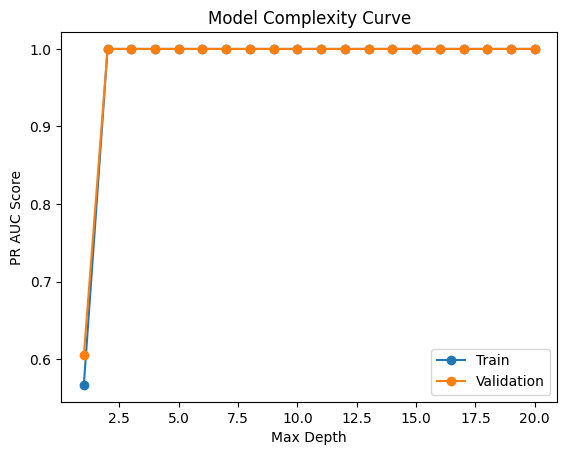

Train Score: 0.9783424371710604
Validation Score: 0.9802569329136965


In [58]:
train_scores, test_scores = list(), list()

values = [i for i in range(1, 21)]

for i in values:
    model = XGBClassifier(max_depth=i)
    model.fit(X_train, y_train)

    train_yhat = model.predict_proba(X_train)[:, 1]
    train_acc = prAUC(y_train, train_yhat)
    train_scores.append(train_acc)

    test_yhat = model.predict_proba(X_test)[:, 1]
    test_acc = prAUC(y_test, test_yhat)
    test_scores.append(test_acc)

plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Validation')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('PR AUC Score')
plt.title('Model Complexity Curve')
plt.show()

print("Train Score:", np.mean(train_scores))
print("Validation Score:", np.mean(test_scores))

**Best Hyperparameter Tuning**

In [66]:
param= {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 2, 3, 4, 5]
}

model = XGBClassifier()

pr_auc_scorer = make_scorer(prAUC, needs_proba=True)

random_search = RandomizedSearchCV(
    model, 
    param_distributions=param, 
    n_iter=10, 
    scoring=pr_auc_scorer, 
    cv=5, 
    random_state=0)

random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)

best_model = random_search.best_estimator_

y_proba = best_model.predict_proba(X_test)[:, 1]
prc_score = prAUC(y_test, y_proba)
print("Test PR AUC Score:", prc_score)


Best Hyperparameters: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1.0}
Test PR AUC Score: 0.9999999999999999


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def prAUC(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

param = {'subsample': 0.9, 
         'n_estimators': 300, 
         'min_child_weight': 2, 
         'max_depth': 3, 
         'learning_rate': 0.3, 
         'gamma': 0.0, 
         'colsample_bytree': 1.0}

prc_score = prAUC(y_test, y_proba)

model = XGBClassifier()
model_tuned = XGBClassifier(**param)

model.fit(X_train, y_train)
model_tuned.fit(X_train, y_train)

y_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

y_proba_tuned = model_tuned.predict_proba(X_test)[:, 1]
y_pred_tuned = model_tuned.predict(X_test)

**Sebelum dan Sesudah Tuning**

In [54]:
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
prc_score = prAUC(y_test, y_proba)

print("Before Tuning")
print("Recall Score:", recall)
print("Precision Score:", precision)
print("PR-AUC Score:", prc_score)

Before Tuning
Recall Score: 1.0
Precision Score: 1.0
PR-AUC Score: 0.9999999999999999


In [65]:
recall_tuned = recall_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
prc_score_tuned = prAUC(y_test, y_proba_tuned)

print("After Tuned")
print("Recall Score:", recall_tuned)
print("Precision Score:", precision_tuned)
print("PR-AUC Score:", prc_score_tuned)

After Tuned
Recall Score: 1.0
Precision Score: 1.0
PR-AUC Score: 0.9999999999999999


__Insight:__
* Dari data sebelum dan sesudah tuning pada model XGBoost tidak terdapat perbedaan tetapi nilainya tetap baik.

Perbandingan Classification Report

In [69]:
report_default = classification_report(y_test, y_pred)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default: \n', report_default)
print()
print('Classification Report Tuned: \n', report_tuned)

Classification Report Default XGBoost: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7729
           1       1.00      1.00      1.00       126

    accuracy                           1.00      7855
   macro avg       1.00      1.00      1.00      7855
weighted avg       1.00      1.00      1.00      7855


Classification Report Tuned XGBoost: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7729
           1       1.00      1.00      1.00       126

    accuracy                           1.00      7855
   macro avg       1.00      1.00      1.00      7855
weighted avg       1.00      1.00      1.00      7855



__Insight:__
* Model XGBoost setelah dituning hyperparameternya memiliki classification report yang baik
* Maka akan menggunkan model yang sudah dituned sebagai model akhir

**Feature Importances**

<Figure size 1000x800 with 0 Axes>

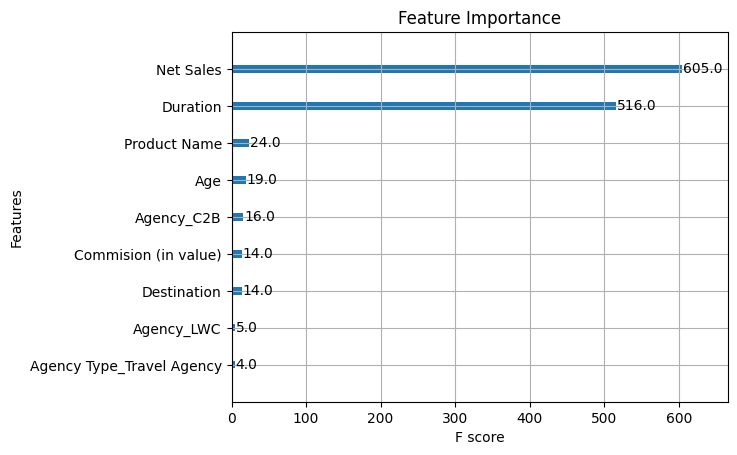

In [50]:
plt.figure(figsize=(10, 8))
plot_importance(model_tuned, max_num_features=10)
plt.title('Feature Importance')
plt.show()

__Insight:__
* Fitur atau kolom terbaik dan paling penting yaitu net sales dan duration, kemudian diikuti product name dan age.
* Fitur yang lain tidak terlalu berpengaruh untuk memprediksi nasabah yang akan mengklaim atau tidak mengkalim travel insurance

### `Conclusion`

In [68]:
print('Classification Report Tuned: \n', report_tuned)

Classification Report Tuned: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7729
           1       1.00      1.00      1.00       126

    accuracy                           1.00      7855
   macro avg       1.00      1.00      1.00      7855
weighted avg       1.00      1.00      1.00      7855



Beberapa hal yang dapat disimpulkan yaitu:

* Bila ingin menggunakan model tersebut, dapat memprediksi nasabah yang akan mengajukan klaim atau tidak dengan akurasi sebesar 100% ditunjkkan dengan hasil precission, recall, dan f1 score.
* Maka dari itu model menunjukkan sangat tepat mengklasifikasikan kasus-kasus yang berpotensi mengajukan klaim asuransi dan yang kemungkinan besar tidak akan mengajukan klaim.
* Dengan hasil prediksi sebesar 100%, maka perusahaan diharapkan tidak akan mengalami kerugian karena salah memprediksi nasabah yang mengajukan klaim atau tidak.

### `Recommendations`

Hal yang dapat dilakukan untuk mengembangkan model agar lebih baik lagi, seperti:

* Menambah fitur atau kolm yang memiliki faktor untuk mengklaim perusahaan seperti kondisi kesehatan (unutk mengetahui apakah nasabah memiliki riwayat sakit atau tidak untuk bepergian), income nasabah (unutk mengetahui apakah nasabah memiliki masalah keuangan atau tidak), aktivitas selama perjalanan (untuk mengetahui aktivitas yang dilakukan selama perjalanan memiliki resiko tinggi atau tidak), dll
* Mencoba algorithm machine learning lainnya serta mencoba hyperparameter unutk tuning kembali.
* Menggunakan teknik oversampling selain random over sampling, seperti SMOTE (Synthetic Minority Over-sampling Technique), ADASYN (Adaptive Synthetic Sampling), Custer-based Oversampling, dll
* Menganalisa data yang mengakibatkan model masih memiliki kesalahan untuk memprediksi agar mengetahui alasannya dan karakteristiknya bagaimana

In [70]:
# Save Model
import pickle
filename = 'Travel_Insurance_XGB_Tuned.sav'
pickle.dump(model_tuned, open(filename, 'wb'))

In [71]:
# Load model
filename = 'Travel_Insurance_XGB_Tuned.sav'
loaded_model = pickle.load(open(filename, 'rb'))